{'buildings' -> 0, 

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 }

In [0]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# Set home directory of this project
home_dir = '/content/gdrive/My Drive/data-science-my-projects/AV-Intel-Scene-Classification-Challenge'

## Read and set up data

In [0]:
# Read data
dataset_dir = os.path.join(home_dir, "dataset")
train_dir = os.path.join(dataset_dir, "train")


train_df = pd.read_csv(dataset_dir + '/train.csv')
train_df.head()

In [0]:
# Read and display an image
image = plt.imread(os.path.join(train_dir, os.listdir(train_dir)[25]))
print("Image shape =", image.shape)
train_input_shape = image.shape
plt.imshow(image)
plt.show()

In [0]:
# Number of unique classes
n_classes = len(train_df.label.unique())
print("Number of unique classes =", n_classes)

## Image Augmentation

In [0]:
# Augment data
batch_size = 32
#train_input_shape = (64, 64, 3)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="training",
                                                    target_size=train_input_shape[0:2],
                                                    shuffle=True,
                                                    batch_size=batch_size)

valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="validation",
                                                    target_size=train_input_shape[0:2],
                                                    shuffle=True,
                                                    batch_size=batch_size)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 13628 images.
Found 3406 images.
Total number of batches = 425 and 106


## Build model

In [0]:
# Load pre-trained model
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

# Add layers at the end
X = resnet50.output
X = Flatten()(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=resnet50.input, outputs=output)

#model.summary()

In [0]:
# Train all layers 
optimizer=Adam(lr=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

n_epoch = 50

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[early_stop, reduce_lr],
                              use_multiprocessing=True,
                              workers=10
                             )

In [0]:
# Train only last few layers
optimizer=Adam(lr=0.0001)

for layer in model.layers[:-6]:
    layer.trainable = False
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

n_epoch = 50

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[early_stop, reduce_lr],
                              use_multiprocessing=True,
                              workers=10
                             )

In [0]:
# Save the model and weights
model_dir = os.path.join(home_dir, "models")
model.save(model_dir + '/resnet50_model.h5')
model.save_weights(model_dir + '/resnet50_weights.h5')

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [0]:
# Evaluate on validation set
result = model.evaluate_generator(generator=valid_generator, verbose=1)
result

107/107 [==============================] - 40s 376ms/step - loss: 0.3636 - acc: 0.9151


[0.36362757830158154, 0.91514975]

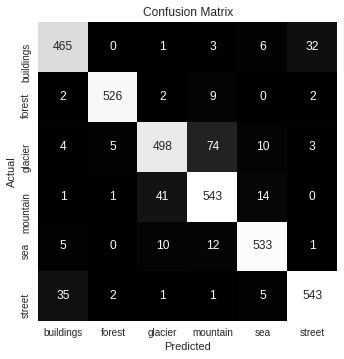

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       507
           1       0.99      0.97      0.98       541
           2       0.90      0.84      0.87       594
           3       0.85      0.91      0.87       600
           4       0.94      0.95      0.94       561
           5       0.93      0.93      0.93       587

   micro avg       0.92      0.92      0.92      3390
   macro avg       0.92      0.92      0.92      3390
weighted avg       0.92      0.92      0.92      3390



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    #y_pred = np.asarray(y_pred).astype('float32').ravel()
    #y_pred = y_pred >= 0.5
    #y_pred = y_pred.astype('int').ravel()
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5])
    sns.heatmap(conf_matrix, annot=True, fmt="d", square=True, cbar=False, 
                cmap=plt.cm.gray, xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred))
    #print("\nAUC: ", roc_auc_score(y_true, y_pred, average='micro'))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## Prepare data for prediction on test set

In [0]:
test_df = pd.read_csv(dataset_dir + "/test_WyRytb0.csv")
test_df.shape

(7301, 1)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    #y_col="label", 
                                                    class_mode=None,
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=1,
                                                    shuffle=False
                                                 )

Found 7301 images.


## Predict and Submit

In [0]:
# Predict on test data
test_generator.reset()
predictions = model.predict_generator(test_generator,verbose=1)
predictions = np.argmax(predictions, axis=1)
#predictions = predictions.astype('int').ravel()
predictions.shape

7301/7301 [==============================] - 206s 28ms/step


(7301,)

In [0]:
# Retrieve filenames
import re
#test_img_ids = [re.split("/", val)[1] for val in test_generator.filenames]
test_img_ids = test_generator.filenames
len(test_img_ids)

7301

In [0]:
# Create dataframe for submission
submission_df = pd.DataFrame({'image_name' : test_img_ids,
                              'label' : predictions })
submission_df.head()

In [0]:
# Create submission file
submission_dir = os.path.join(home_dir, "submissions")
submission_df.to_csv(submission_dir + '/submission_resnet50.csv', index=False)